Описание задачи: Выбираем 20 мест для размещения рекламных баннеров.


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/ii_reserve/' + 'checkins.dat'

df = pd.read_csv(path, sep='|')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df

,id,user_id,venue_id,latitude,longitude,created_at
0,---------+---------+----------+---------------...,NaN,NaN,NaN,NaN,NaN
1,984301,2041916.0,5222.0,,,2012-04-21 17:39:01
2,984222,15824.0,5222.0,38.8951118,-77.0363658,2012-04-21 17:43:47
3,984315,1764391.0,5222.0,,,2012-04-21 17:37:18
4,984234,44652.0,5222.0,33.800745,-84.41052,2012-04-21 17:43:43
...,...,...,...,...,...,...
1021963,956119,1139114.0,29488.0,42.439479,-83.7438303,2012-04-13 11:36:44
1021964,956447,2088020.0,4432.0,,,2012-04-13 12:58:05
1021965,956733,960666.0,60.0,42.331427,-83.0457538,2012-04-13 21:56:19
1021966,957139,1771518.0,10935.0,,,2012-04-14 02:44:52


In [ ]:
df.dtypes

   id                     object
 user_id                 float64
 venue_id                float64
     latitude             object
     longitude            object
     created_at           object
dtype: object

Подготовка данных:

изменение названий столбцов

удаляются строки с мусорными значениями latitude и longitude	

берутся первые 100 000 строк

берутся только столбцы latitude и longitude

In [ ]:
df.rename(columns={'     latitude      ' : 'latitude', '     longitude     ' : 'longitude'}, inplace=True)

In [ ]:
df['latitude'].replace('                   ', np.nan, inplace=True)
df['longitude'].replace('                   ', np.nan, inplace=True)
df.dropna(subset=['latitude', 'longitude'],inplace=True)

In [ ]:
df = df.iloc[0:100000, :]
df = df.loc[:, ['latitude', 'longitude']]

In [ ]:
df['latitude'] = pd.to_numeric(df['latitude'])
df['longitude'] = pd.to_numeric(df['longitude'])

In [ ]:
df

,latitude,longitude
2,38.895112,-77.036366
4,33.800745,-84.410520
8,45.523452,-122.676207
10,40.764462,-111.904565
11,33.448377,-112.074037
...,...,...
233789,33.575000,-117.725556
233790,37.629349,-122.400087
233794,29.762884,-95.383061
233798,32.802955,-96.769923


In [ ]:
df.dtypes

latitude     float64
longitude    float64
dtype: object

MeanShift

In [ ]:
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.cluster import MeanShift, estimate_bandwidth

from itertools import cycle

Ndarray из точек

In [ ]:
X = np.array(df.values.tolist())

Возьмем вместо автоматически определенного bandwidth (11.88) рекомендуемое значение 0.1

In [ ]:
bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=500)
print(bandwidth)
bandwidth = 0.1

11.881350925204242


In [ ]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms.fit(X)

labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels, return_counts=True)
labels_unique_df = pd.DataFrame(labels_unique).T
popular_places_id = labels_unique_df.sort_values(1, ascending=False)[0][:20].values
df_cent = pd.DataFrame(cluster_centers)
main_clusters = df_cent.loc[popular_places_id]

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print("number of estimated clusters : %d" % n_clusters_)

number of estimated clusters : 3093


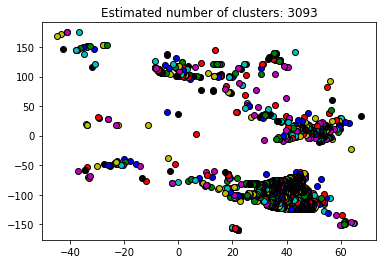

In [ ]:
plt.figure(1)
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

result = []

for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=6,
    )
plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [ ]:
largest_clusters = str(main_clusters).split()[2:]

for i in range(1, len(largest_clusters), 3):
    print(largest_clusters[i], largest_clusters[i+1], sep=', ') 

40.717716, -73.991835
33.448410, -112.074004
33.446380, -111.901888
37.688682, -122.409330
41.878244, -87.629843
38.886165, -77.048783
33.357345, -111.822654
33.766636, -84.393289
42.363219, -71.073688
47.606245, -122.332044
36.117229, -115.171073
34.060398, -118.248709
44.977948, -93.267301
30.267184, -97.743119
39.951680, -75.162736
39.735830, -104.986580
32.980893, -117.078118
32.803021, -96.769897
32.711344, -117.153639
32.221713, -110.926535


Результат для MeanShift

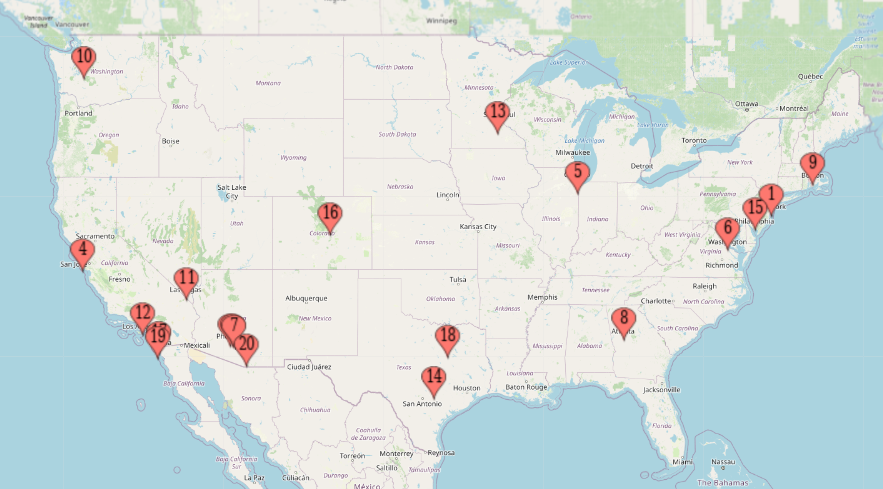

In [ ]:
DBSCAN

sklearn.cluster._dbscan.DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

Estimated number of clusters: 527
Estimated number of noise points: 6216


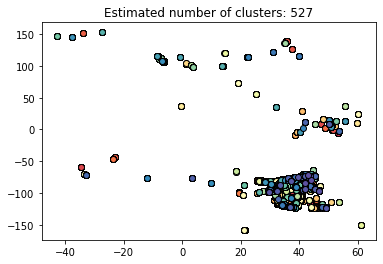

In [ ]:
db = DBSCAN(eps=0.1, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)


unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

result = []

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]

    result.append(xy)

    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_clusters_)
plt.show()

In [ ]:
result.sort(reverse=True, key=len)
biggest_clusters = result[:20]

In [ ]:
for el in biggest_clusters:
    sum_x = 0
    sum_y = 0
    for x, y in el:
        sum_x += x
        sum_y += y
    print(sum_x/len(el), sum_y/len(el), sep=', ')

40.67298755118918, -74.06725401362937
33.439078930306096, -111.99022411435872
37.651118773709534, -122.2844257520296
33.95558258415613, -118.13126357323013
41.89333770503945, -87.70966556854312
38.96351725613345, -77.02523448533204
33.80926276935102, -84.38809406810883
42.370974370121665, -71.13492656782357
47.60246229692314, -122.29591769633349
44.95699365372562, -93.26149357366906
36.1173084828341, -115.17101003502961
25.94704831276442, -80.2010634426005
39.74006040672014, -104.98882720322466
32.85028850713525, -96.7515542051535
30.26718361698159, -97.74311928133027
28.543584271100286, -81.39540378919911
32.7208900825742, -117.14185195694714
32.98089338217789, -117.07811797821923
43.03609728503855, -87.93685286086954
32.2217131518074, -110.92653515261165


20 наибольших кластеров, найденных с помощбю алгоритма DBSCAN, также находятся в США

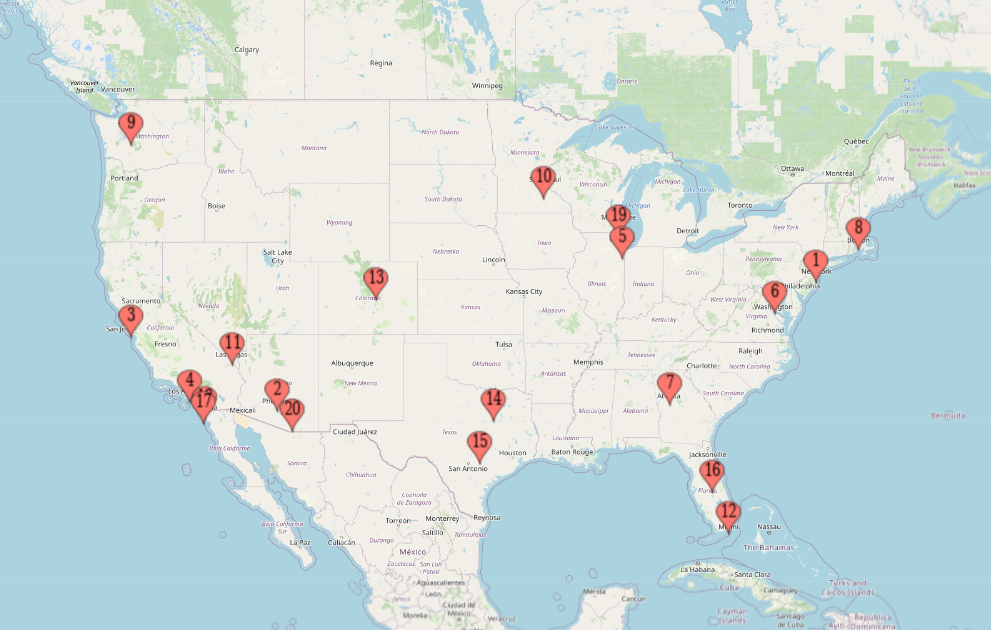

Вывод: предложенные двумя алгоритмами результаты ненамного отличаются, но так как DBSCAN - это более универсальный и точный алгоритм, то лучше взять точки, предложенные им. 
Также стоит сказать, что многие факторы, важные для размещения рекламы, здесь не учитываются, а обрабатываемый датасет построен на действиях пользователей:

"Пользователи отмечаются («check-in») в различных заведениях с помощью мобильной версии веб-сайта, SMS-сообщения или же специального приложения, разработанного под определённую ОС мобильного устройства. Каждая такая отметка позволяет пользователю зарабатывать foursquare-баллы, а в некоторых случаях и «бейджи»."

Датасет нельзя счиать объективным, хотя бы потому что сервис forsquare может пользоваться разной популярностью в разных странах.